In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
#Path definition
user_path = os.path.expanduser('~')
desktop_path = os.path.join(user_path, "Desktop")
table_detection_path = os.path.join(desktop_path, "table_detection")
workspace_path = os.path.join(table_detection_path, "workspace")
training_demo_path = os.path.join(workspace_path, "training_demo")
trial_table = os.path.join(desktop_path, "table_trial")

In [11]:
image_paths = []
for image_name in os.listdir(trial_table):
    image_paths.append(os.path.join(trial_table, image_name))
print(image_paths)

['C:\\Users\\METE\\Desktop\\table_trial\\table_6.png']


In [12]:
MODEL_DATE = '20230106'
MODEL_NAME = 'table_efficientdet'
LABEL_FILENAME = 'label_map.pbtxt'
PATH_TO_LABELS = os.path.join(training_demo_path, "annotations", LABEL_FILENAME)
PATH_TO_MODEL_DIR = os.path.join(training_demo_path, "models")
PATH_TO_CFG = os.path.join(PATH_TO_MODEL_DIR, "table_efficientdet", "pipeline.config" )
PATH_TO_CKPT = os.path.join(PATH_TO_MODEL_DIR, "table_efficientdet")

In [13]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder


print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 4.789204835891724 seconds


In [14]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [15]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

In [16]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

Running inference for C:\Users\METE\Desktop\table_trial\table_6.png... Done


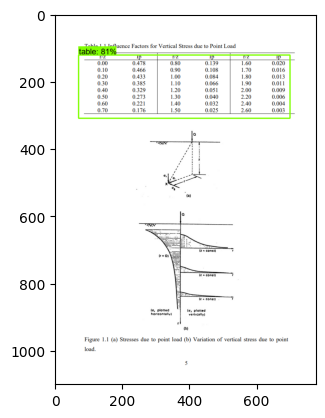

In [17]:
for image_path in image_paths:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)
    img_height, img_width = image_np.shape[0], image_np.shape[1]
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.5,
            agnostic_mode=False)
    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

In [18]:
boxes = detections['detection_boxes']
# get all boxes from an array
max_boxes_to_draw = boxes.shape[0]
# get scores to get a threshold
scores = detections['detection_scores']
# this is set as a default but feel free to adjust it to your needs
min_score_thresh=.5
# iterate over all objects found
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores is None or scores[i] > min_score_thresh:
        # boxes[i] is the box which will be drawn
        print ("This box is gonna get used", boxes[i])

This box is gonna get used [0.11133035 0.08990811 0.28149554 0.8977194 ]


In [19]:
top_y = boxes[0][0]*img_height
left_x = boxes[0][1]*img_width
bottom_y = boxes[0][2]*img_height
right_x = boxes[0][3]*img_width
print(top_y, left_x, bottom_y, right_x)

122.46338799595833 69.85860000550747 309.64509546756744 697.5279607772827


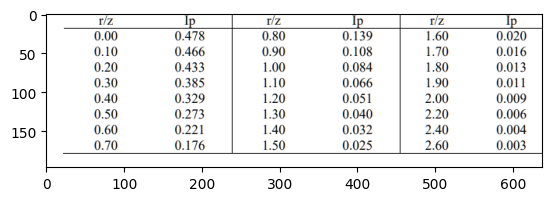

In [20]:
import cv2
import math
image_path = image_paths[0]
img = cv2.imread(image_path)
extra_pixels = 5
y_top = int(top_y)-extra_pixels
y_bottom = int(bottom_y)+extra_pixels
x_left = int(left_x) - extra_pixels
x_right = int(right_x) + extra_pixels
roi = img[y_top:y_bottom,x_left:x_right]
cv2.imwrite("roi.png", roi)
plt.imshow(roi)
plt.show()

Looking for C:\Users\METE\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\METE\.keras-ocr\crnn_kurapan.h5
3/3 [==============================] - 3s 162ms/step


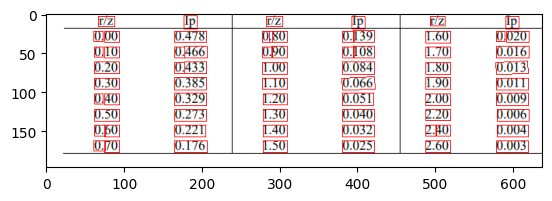

In [21]:
import keras_ocr
roi_path = os.path.join(training_demo_path, "roi.png")
pipeline = keras_ocr.pipeline.Pipeline()
image = keras_ocr.tools.read(roi_path)
prediction = pipeline.recognize([image])[0]
boxes = [value[1] for value in prediction]
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=boxes, color=(255, 0, 0), thickness=1)
plt.imshow(canvas)
plt.show()

In [22]:
import itertools
readings = [value[0] for value in prediction]
value_center_list = []
for box in boxes:
    x_center = []
    y_center = []
    x_sum = 0
    y_sum = 0
    for point in box:
        x_sum += point[0]
        y_sum += point[1]
    x_center = int(x_sum/4)
    y_center = int(y_sum/4)
    value_center_list.append([x_center, y_center])
corrected_readings = value_center_list
for i in range(len(value_center_list)):
    value_center_list[i].append(readings[i])
sensivity_x = 25
sensivity_y = 3  
for data_1, data_2 in itertools.combinations(value_center_list, 2):
    x_pred1 = data_1[0]
    x_pred2 = data_2[0]
    y_pred1 = data_1[1]
    y_pred2 = data_2[1]
    x_avg = int((x_pred1+x_pred2)/2)
    y_avg = int((y_pred1+y_pred2)/2) 
    if y_pred1 - sensivity_y <= y_pred2 <= y_pred1 + sensivity_y:
        if x_pred1 - sensivity_x <= x_pred2 <= x_pred1 + sensivity_x:
            if x_pred1 < x_pred2:
                corrected_text = data_1[2] + data_2[2]
                corrected_readings.remove(data_1)
                corrected_readings.remove(data_2)
                corrected_readings.append([x_avg, y_avg, corrected_text])
            else:
                corrected_text = data_2[2] + data_1[2]
                corrected_readings.remove(data_1)
                corrected_readings.remove(data_2)
                corrected_readings.append([x_avg, y_avg, corrected_text])
    

In [23]:
min_y_coordinate = y_bottom
for coordinate in value_center_list:
    if coordinate[1] < min_y_coordinate:
        min_y_coordinate = coordinate[1]
print(min_y_coordinate)

10


In [24]:
search_range = 5
first_row = []
for coordinate in corrected_readings:
    if min_y_coordinate-search_range <= coordinate[1] <= min_y_coordinate+search_range:
        first_row.append(coordinate)
print(first_row)      

[[185, 11, 'lp'], [77, 10, 'riz'], [293, 10, 'riz'], [401, 12, 'lp'], [503, 10, 'rz'], [599, 12, 'lp']]


In [25]:
number_of_columns = len(first_row)
number_of_rows = int(len(corrected_readings)/number_of_columns)
print(number_of_columns)
print(number_of_rows)

6
9


In [26]:
sorted_for_x = sorted(corrected_readings, key=lambda x: x[0])

In [27]:
numpy_list_of_array = np.array(sorted_for_x)
reshaped = numpy_list_of_array.reshape((6,9,3))
final_list = [sorted(values, key = lambda x: int(x[1])) for values in reshaped]

In [28]:
import pandas as pd
df = pd.DataFrame(final_list)
df = df.T
df.head()

,0,1,2,3,4,5
0,"[77, 10, riz]","[185, 11, lp]","[293, 10, riz]","[401, 12, lp]","[503, 10, rz]","[599, 12, lp]"
1,"[75, 29, oo0]","[185, 30, 0478]","[291, 30, o50]","[398, 29, o139]","[504, 30, 160]","[595, 29, o020]"
2,"[75, 49, o10]","[181, 49, o466]","[292, 49, o90]","[398, 49, o10s]","[504, 50, 170]","[600, 49, 0016]"
3,"[78, 69, 020]","[181, 69, o433]","[294, 70, 100]","[401, 70, 0084]","[504, 70, 150]","[599, 70, 0013]"
4,"[78, 90, 030]","[185, 90, 0385]","[294, 90, 110]","[402, 90, 0066]","[504, 89, 190]","[599, 90, o011]"


In [29]:
for i in range(number_of_columns):
    df[i] = df[i].apply(lambda x: x[2:])
df.head()

,0,1,2,3,4,5
0,[riz],[lp],[riz],[lp],[rz],[lp]
1,[oo0],[0478],[o50],[o139],[160],[o020]
2,[o10],[o466],[o90],[o10s],[170],[0016]
3,[020],[o433],[100],[0084],[150],[0013]
4,[030],[0385],[110],[0066],[190],[o011]


In [30]:
print(df)

       0        1      2       3      4        5
0  [riz]     [lp]  [riz]    [lp]   [rz]     [lp]
1  [oo0]   [0478]  [o50]  [o139]  [160]   [o020]
2  [o10]   [o466]  [o90]  [o10s]  [170]   [0016]
3  [020]   [o433]  [100]  [0084]  [150]   [0013]
4  [030]   [0385]  [110]  [0066]  [190]   [o011]
5  [o40]   [0329]  [120]  [0051]  [200]  [ol0o9]
6  [050]   [0275]  [130]  [0040]  [220]   [0006]
7  [o60]   [0221]  [140]  [0052]  [240]   [0004]
8  [o70]  [01176]  [150]  [0025]  [260]   [0005]
